# TP3 - Arbre et Random Forest : Prédiction du churn

On s'intéresse à un problème de **churn** : on souhaite savoir si un client va quitter ou non la banque considérée dans le [dataset](https://www.kaggle.com/datasets/gauravtopre/bank-customer-churn-dataset).
Nous allons utiliser des arbres de décisions et des random forest pour répondre à ce problème.

## Contrôle de la qualité de donnée

Commençons par importer les données et les observer.

In [195]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="whitegrid")

df = pd.read_csv("ChurnPrediction.csv")
df.head(10)

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
5,15574012,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
6,15592531,822,France,Male,50,7,0.00,2,1,1,10062.80,0
7,15656148,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1
8,15792365,501,France,Male,44,4,142051.07,2,0,1,74940.50,0
9,15592389,684,France,Male,27,2,134603.88,1,1,1,71725.73,0


La colonne *customer_id* est unique et ne sert pas dans la prédiction. Notons que nous avons à la fois des données numérique et catégorielle.

**Consigne** : Supprimer la colonne *customer_id*

In [196]:
# Supprimer la colonne customer_id
df = df.drop(columns=['customer_id'])
df.head(10)

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
5,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
6,822,France,Male,50,7,0.00,2,1,1,10062.80,0
7,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1
8,501,France,Male,44,4,142051.07,2,0,1,74940.50,0
9,684,France,Male,27,2,134603.88,1,1,1,71725.73,0


**Consigne** : En utilisant la méthode [`describe`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.describe.html), identifier s'il y a des valeurs qui paraissent aberrante dans les données numériques.

In [197]:
df.describe()

,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


**Consigne** : Que peut-on dire des colonnes *tenure*, *products_number*, *credit_card* et *active_member* ?

In [198]:
# Analyzing the columns 'tenure', 'products_number', 'credit_card', and 'active_member'

# Tenure: This column represents the number of years the customer has been with the bank. 
# It ranges from 0 to 10, which seems reasonable for a banking dataset.

# Products_number: This column indicates the number of products the customer has with the bank. 
# It ranges from 1 to 4, which is also reasonable.

# Credit_card: This is a binary column indicating whether the customer has a credit card (1) or not (0). 
# The values are as expected for a binary column.

# Active_member: This is another binary column indicating whether the customer is an active member (1) or not (0). 
# The values are as expected for a binary column.

# Overall, these columns do not show any aberrant values and seem to be within expected ranges.

**Consigne** : Calculer la proportion de déséquilibre.

In [199]:
# Calculer la proportion de déséquilibre
churn_counts = df['churn'].value_counts()
imbalance_ratio = churn_counts[1] / churn_counts[0]
print(f"Proportion de déséquilibre (churn/non-churn): {imbalance_ratio:.2f}")

Proportion de déséquilibre (churn/non-churn): 0.26


**Consigne** : En utilisant la fonction `agregate_column`, explorer les champs catégoriels.

In [200]:
def agregate_column(column):
    grouped = df.groupby(by=column, as_index=False).agg({"churn": "mean"})
    return grouped

In [201]:
# Explorer les champs catégoriels en utilisant la fonction agregate_column
categorical_columns = ['country', 'gender', 'credit_card', 'active_member']

for column in categorical_columns:
    print(f"Exploration de la colonne : {column}")
    print(agregate_column(column))
    print("\n")

Exploration de la colonne : country
   country     churn
0   France  0.161548
1  Germany  0.324432
2    Spain  0.166734


Exploration de la colonne : gender
   gender     churn
0  Female  0.250715
1    Male  0.164559


Exploration de la colonne : credit_card
   credit_card     churn
0            0  0.208149
1            1  0.201843


Exploration de la colonne : active_member
   active_member     churn
0              0  0.268509
1              1  0.142691




## Préparation des données

Maintenant que l'on a *un peu* observé les données, il nous reste à les préparer pour l'entraînement.

**Consigne** : Séparer le dataset en *X* et *y*

In [202]:
# Séparer le dataset en X et y
X = df.drop(columns=['churn'])
y = df['churn']

Puisque *X* est composé de donnée numérique comme catégorielle et que l'implémentation scikit-learn ne peut pas prendre en compte les données catégorielles, il faut les convertir.

**Consigne** : en utilisant la méthode [`get_dummies`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html), convertir avec la méthode One-Hot-Encoding les données catégorielles en données numérique. On aura prit soin de capitaliser sur les observations précédentes.

In [203]:
# Convertir les données catégorielles en données numériques avec One-Hot-Encoding
X = pd.get_dummies(X, columns=categorical_columns)
X.head()

,credit_score,age,tenure,balance,products_number,estimated_salary,country_France,country_Germany,country_Spain,gender_Female,gender_Male,credit_card_0,credit_card_1,active_member_0,active_member_1
0,619,42,2,0.00,1,101348.88,True,False,False,True,False,False,True,False,True
1,608,41,1,83807.86,1,112542.58,False,False,True,True,False,True,False,False,True
2,502,42,8,159660.80,3,113931.57,True,False,False,True,False,False,True,True,False
3,699,39,1,0.00,2,93826.63,True,False,False,True,False,True,False,True,False
4,850,43,2,125510.82,1,79084.10,False,False,True,True,False,False,True,False,True


## Modélisation : Arbre

On souhaite prédire le churn a partir des données que l'on vient de préparer à l'aide d'un arbre de décision. Nous allons réaliser une validation croisée pour avoir une meilleure vision des performances de l'algorithme.
Cependant, le dataset est déséquilibré, donc nous ne pouvons pas réaliser une validation croisée sans prendre en compte ce déséquilibre.

**Consigne** : Avant de régler ce problème, Construire une fonction `cross_validation_performance` qui prend en paramètre un vecteur *vector* et qui affiche la moyenne et l'écart-type au format suivant : *moyenne (+/- ecart-type)*. On veillera à transformer le vecteur au format *numpy* avant les traitements.

In [204]:
import numpy as np

def cross_validation_performance(vector):
    vector = np.array(vector)
    mean = np.mean(vector)
    std = np.std(vector)
    print(f"{mean:.2f} (+/- {std:.2f})")

**Consigne** : Compléter le code suivant. Il utilise la méthode [`StratifiedKFold`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html) pour entraîner un [arbre de décision](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn-tree-decisiontreeclassifier). Puis afficher les performances avec la fonction `cross_validation_performance`.

On ne souhaite plus avoir ce bloc de code systématique, nous allons donc en faire une fonction. Pour pouvoir tester plusieurs paramétrage de l'arbre, on doit être capable de lui fournir des paramètres. Voici un exemple de l'utilisation :

In [205]:
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score

# cv = 5
# folds = StratifiedKFold(n_splits=cv).split(X, y)
# performances = []

# for (train_index, test_index) in folds:
#     X_train, X_test = ..., ...
#     y_train, y_test = ..., ...
    
#     model_trained = DecisionTreeClassifier().fit(..., ...)
#     y_pred = model_trained.predict(...)
#     ...

# cross_validation_performance(performances)

Il est possible de donner comme input à une fonction ou une classe un dictionnaire. Dans le cas d'un arbre :

In [206]:
parameters = {
    "criterion": "gini",
    "max_depth": 8,
    "min_samples_leaf": 20
}

model = DecisionTreeClassifier(**parameters)

**Consigne** : En exploitant ce fonctionnement, construire une fonction `stratified_cross_validation` qui prends en paramètre :
* *X*: le dataset des features
* *y*: le vecteur réponse
* *model*: le modèle que l'on veut tester, au format scikit-learn
* *parameters*: le dictionnaire de paramètres à transmettre à *model*
* *metric*: la métrique avec laquelle on mesure les performances de *model*, au format scikit-learn
* *cv*: le nombre de pli de la validation croisée

Elle devra renvoyer les performances sur chacun des plis.

In [207]:
def stratified_cross_validation(X, y, model, parameters, metric=f1_score, cv=5):
    folds = StratifiedKFold(n_splits=cv).split(X, y)
    performances = []

    for train_index, test_index in folds:
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model_trained = model(**parameters).fit(X_train, y_train)
        y_pred = model_trained.predict(X_test)
        performance = metric(y_test, y_pred)
        performances.append(performance)
    cross_validation_performance(performances)
    return performances
stratified_cross_validation(X, y, DecisionTreeClassifier, parameters)

0.58 (+/- 0.02)


[np.float64(0.5740458015267176),
 np.float64(0.6017441860465116),
 np.float64(0.5548961424332344),
 np.float64(0.5982658959537572),
 np.float64(0.5522388059701493)]

## Impact de la profondeur

On souhaiterai mesurer l'importance de la profondeur d'un arbre pour ce problème.

**Consigne** : A l'aide de la fonction précédente, répondre à la problématique avec un affichage.

In [208]:
def plot_performance(parameters, performances, color=None, label=None,confidence=3):
    if color is None: color=sns.color_palette()[0]
    if label is None: label=""
        
    mean = [np.mean(performance) for performance in performances]
    deviation = [np.std(performance) for performance in performances]
    
    mean, deviation = np.array(mean), np.array(deviation)
    
    plt.fill_between(parameters, mean - confidence*deviation, mean + confidence*deviation, alpha=0.15, color=color)
    plt.plot(parameters, mean, 'o-', color=color, label=label)

Profondeur: 3: 
0.40 (+/- 0.02)
Profondeur: 5: 
0.54 (+/- 0.06)
Profondeur: 7: 
0.56 (+/- 0.02)
Profondeur: 9: 
0.57 (+/- 0.03)
Profondeur: 11: 
0.58 (+/- 0.02)
Profondeur: 13: 
0.58 (+/- 0.02)
Profondeur: 15: 
0.58 (+/- 0.02)


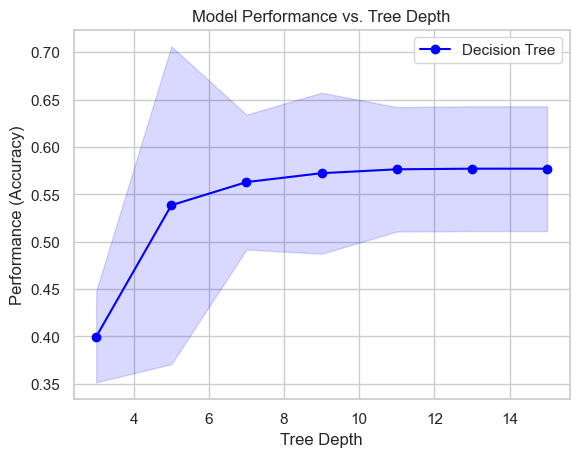

In [209]:
# Mesurer l'importance de la profondeur d'un arbre pour ce problème

depths = [3, 5, 7, 9, 11, 13, 15]
performances = []

for depth in depths:
    parameters = {
        "criterion": "gini",
        "max_depth": depth,
        "min_samples_leaf": 20
    }
    print(f"Profondeur: {depth}: ")
    performance = stratified_cross_validation(X, y, DecisionTreeClassifier, parameters)
    performances.append(performance)

# Plotting the performances against the depths
plot_performance(depths, performances, label="Decision Tree", color="blue")
# Adding titles and labels
plt.title("Model Performance vs. Tree Depth")
plt.xlabel("Tree Depth")
plt.ylabel("Performance (Accuracy)")
plt.grid(True)
plt.legend()

# Show the plot
plt.show()

Cette performance correspond en réalité au seuil 0.5. On souhaiterai être capable de trouver un seuil qui maximise le f1-score. 

## Trouver le seuil qui maximise une métrique

Pour le faire, nous allons avoir besoin de trois bases :
* Une base d'entraînement (*X_train*, *y_train*) : **entraîner** le modèle
* Une base de validation (*X_valid*, *y_valid*) : **trouver** le meilleur seuil
* Une base de test (*X_test*, *y_test*) : **tester** la performance sur des données non vues

**Consigne** : Générer les trois bases à l'aide la fonction [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split), en prenant soin de conserver le même déséquilibre sur les trois bases.

In [210]:
from sklearn.model_selection import train_test_split

# Générer les trois bases en conservant le même déséquilibre
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_valid.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 6000
Validation set size: 2000
Test set size: 2000


**Consigne** : Entraîner un arbre puis prédire les probabilités d'être de la classe d'intérêt pour le dataset de validation. Les stocker dans une variable *y_proba*.

In [211]:
# Entraîner un arbre puis prédire les probabilités d'être de la classe d'intérêt pour le dataset de validation
model = DecisionTreeClassifier(**parameters)
model.fit(X_train, y_train)
y_proba = model.predict_proba(X_valid)[:, 1]

**Consigne** : Construire une fonction `find_best_treshold` qui prends en paramètre :
* *y_true* : vecteur des classes attendues
* *y_proba* : vecteur de probabilité estimé des classes
* *metric* : métrique à optimiser, au format scikit-learn
Elle revoit la meilleure performance et le meilleur seuil pour la métrique sélectionnée

In [212]:
from sklearn.metrics import f1_score

def find_best_threshold(y_true, y_proba, metric=f1_score):
    best_threshold = 0.0
    best_performance = 0.0

    for threshold in np.arange(0.0, 1.01, 0.01):
        y_pred = (y_proba >= threshold).astype(int)
        performance = metric(y_true, y_pred)
        if performance > best_performance:
            best_performance = performance
            best_threshold = threshold

    return best_performance, best_threshold

**Consigne** : Utiliser la fonction `find_best_threshold` sur le jeu de validation, et comparer avec la performance obtenue sur le jeu de test.

In [213]:
# Utiliser la fonction find_best_threshold sur le jeu de validation
best_performance, best_threshold = find_best_threshold(y_valid, y_proba)
print(f"Meilleure performance sur le jeu de validation: {best_performance:.2f} avec un seuil de {best_threshold:.2f}")

# Prédire les probabilités sur le jeu de test
y_proba_test = model.predict_proba(X_test)[:, 1]

# Utiliser le meilleur seuil pour prédire les classes sur le jeu de test
y_pred_test = (y_proba_test >= best_threshold).astype(int)

# Calculer la performance sur le jeu de test
test_performance = f1_score(y_test, y_pred_test)
print(f"Performance sur le jeu de test: {test_performance:.2f}")

Meilleure performance sur le jeu de validation: 0.61 avec un seuil de 0.40
Performance sur le jeu de test: 0.59


**Consigne** : Reprendre la fonction `stratified_cross_validation` et la modifier pour afficher la meilleure performance que l'on puisse obtenir, avec en plus la valeur du seuil.

In [214]:
def stratified_cross_validation(X, y, model, parameters, metric=f1_score, cv=3):
    folds = StratifiedKFold(n_splits=cv).split(X, y)
    performances = []
    thresholds = []

    for train_index, test_index in folds:
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model_trained = model(**parameters).fit(X_train, y_train)
        y_proba = model_trained.predict_proba(X_test)[:, 1]
        
        best_performance, best_threshold = find_best_threshold(y_test, y_proba, metric)
        performances.append(best_performance)
        thresholds.append(best_threshold)
    print(f"Meilleur seuil moyen: {np.mean(thresholds):.2f} (+/- {np.std(thresholds):.2f})")
    cross_validation_performance(performances)
    return performances
stratified_cross_validation(X, y, DecisionTreeClassifier, parameters)

Meilleur seuil moyen: 0.37 (+/- 0.04)
0.59 (+/- 0.01)


[np.float64(0.5998568360773086),
 np.float64(0.5828125),
 np.float64(0.5922190201729106)]

## Impact de la profondeur : le retour

Maintenant que l'on sait obtenir la meilleur version de chaque algorithme, on souhaite mesurer un peu mieux l'impact de la profondeur.

**Consigne** : A l'aide de la fonction précédente, répondre à la problématique avec un affichage.

Profondeur: 3: 
Meilleur seuil moyen: 0.24 (+/- 0.00)
0.54 (+/- 0.01)
Profondeur: 5: 
Meilleur seuil moyen: 0.33 (+/- 0.05)
0.59 (+/- 0.01)
Profondeur: 7: 
Meilleur seuil moyen: 0.33 (+/- 0.04)
0.60 (+/- 0.01)
Profondeur: 9: 
Meilleur seuil moyen: 0.34 (+/- 0.01)
0.59 (+/- 0.00)
Profondeur: 11: 
Meilleur seuil moyen: 0.34 (+/- 0.07)
0.59 (+/- 0.01)
Profondeur: 13: 
Meilleur seuil moyen: 0.37 (+/- 0.04)
0.59 (+/- 0.01)
Profondeur: 15: 
Meilleur seuil moyen: 0.37 (+/- 0.04)
0.59 (+/- 0.01)


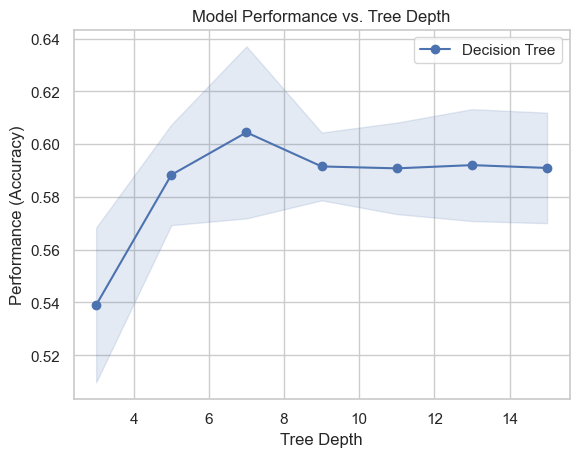

In [215]:
# Mesurer l'importance de la profondeur d'un arbre pour ce problème avec un affichage

depths = [3, 5, 7, 9, 11, 13, 15]
performances = []

for depth in depths:
    parameters = {
        "criterion": "gini",
        "max_depth": depth,
        "min_samples_leaf": 20
    }
    print(f"Profondeur: {depth}: ")
    performance = stratified_cross_validation(X, y, DecisionTreeClassifier, parameters)
    performances.append(performance)

# Plotting the performances against the depths
plot_performance(depths, performances, color='b', label='Decision Tree')
# Adding titles and labels
plt.title("Model Performance vs. Tree Depth")
plt.xlabel("Tree Depth")
plt.ylabel("Performance (Accuracy)")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

On souhaiterai avoir une représentation visuelle de cet affichage. Pour ce faire, on définit la fonction suivante.

**Consigne** : en reprenant la question précédente (en adaptant), et en utilisant la fonction `plot_performance`, montrer visuellement l'impact de la profondeur sur la performance.

## Et la Random Forest ?

On s'intéresse maintenant à la Random Forest. On souhaite mesurer la même chose que pour l'arbre.

**Consigne** : reproduire la même étude, mais avec une Random Forest de 50 arbres.

Profondeur: 3: 
Meilleur seuil moyen: 0.25 (+/- 0.01)
0.58 (+/- 0.01)
Profondeur: 5: 
Meilleur seuil moyen: 0.30 (+/- 0.02)
0.60 (+/- 0.01)
Profondeur: 7: 
Meilleur seuil moyen: 0.30 (+/- 0.02)
0.61 (+/- 0.01)
Profondeur: 9: 
Meilleur seuil moyen: 0.29 (+/- 0.02)
0.61 (+/- 0.02)
Profondeur: 11: 
Meilleur seuil moyen: 0.32 (+/- 0.01)
0.62 (+/- 0.01)
Profondeur: 13: 
Meilleur seuil moyen: 0.29 (+/- 0.01)
0.62 (+/- 0.01)
Profondeur: 15: 
Meilleur seuil moyen: 0.30 (+/- 0.01)
0.62 (+/- 0.02)


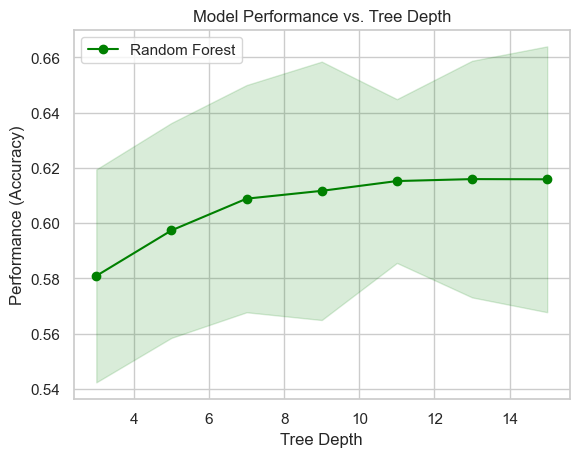

In [216]:
from sklearn.ensemble import RandomForestClassifier

# Mesurer l'importance de la profondeur d'une Random Forest pour ce problème

depths = [3, 5, 7, 9, 11, 13, 15]
performances_rf = []

for depth in depths:
    parameters_rf = {
        "n_estimators": 50,
        "criterion": "gini",
        "max_depth": depth,
        "min_samples_leaf": 20,
        "random_state": 42
    }
    print(f"Profondeur: {depth}: ")
    performance_rf = stratified_cross_validation(X, y, RandomForestClassifier, parameters_rf)
    performances_rf.append(performance_rf)

# Plotting the performances against the depths for Random Forest
plot_performance(depths, performances_rf, color='green', label='Random Forest')
# Adding titles and labels
plt.title("Model Performance vs. Tree Depth")
plt.xlabel("Tree Depth")
plt.ylabel("Performance (Accuracy)")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

**Consigne** : Afficher sur le même graphique, avec une légende, les performances pour un arbre et pour une Random Forest.

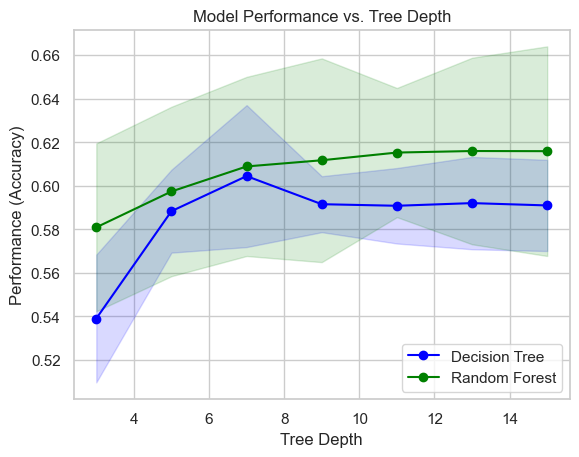

In [217]:
# Plotting the performances against the depths for both Decision Tree and Random Forest

# Plotting Decision Tree performances
plot_performance(depths, performances, color='blue', label='Decision Tree')

# Plotting Random Forest performances
plot_performance(depths, performances_rf, color='green', label='Random Forest')

# Adding titles and labels
plt.title("Model Performance vs. Tree Depth")
plt.xlabel("Tree Depth")
plt.ylabel("Performance (Accuracy)")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

## Et maintenant ?

Il existe d'autres hyperparamètres important dans ces modèles. Reproduire les études, et comparer les performances entre arbres et Random Forest voire Extra-Trees.

Decision Tree - Profondeur: 3: 
Meilleur seuil moyen: 0.24 (+/- 0.00)
0.54 (+/- 0.01)
Decision Tree - Profondeur: 5: 
Meilleur seuil moyen: 0.33 (+/- 0.05)
0.59 (+/- 0.01)
Decision Tree - Profondeur: 7: 
Meilleur seuil moyen: 0.33 (+/- 0.04)
0.60 (+/- 0.01)
Decision Tree - Profondeur: 9: 
Meilleur seuil moyen: 0.34 (+/- 0.01)
0.59 (+/- 0.00)
Decision Tree - Profondeur: 11: 
Meilleur seuil moyen: 0.34 (+/- 0.07)
0.59 (+/- 0.01)
Decision Tree - Profondeur: 13: 
Meilleur seuil moyen: 0.37 (+/- 0.04)
0.59 (+/- 0.01)
Decision Tree - Profondeur: 15: 
Meilleur seuil moyen: 0.37 (+/- 0.04)
0.59 (+/- 0.01)
Random Forest - Profondeur: 3: 
Meilleur seuil moyen: 0.25 (+/- 0.01)
0.58 (+/- 0.01)
Random Forest - Profondeur: 5: 
Meilleur seuil moyen: 0.30 (+/- 0.02)
0.60 (+/- 0.01)
Random Forest - Profondeur: 7: 
Meilleur seuil moyen: 0.30 (+/- 0.02)
0.61 (+/- 0.01)
Random Forest - Profondeur: 9: 
Meilleur seuil moyen: 0.29 (+/- 0.02)
0.61 (+/- 0.02)
Random Forest - Profondeur: 11: 
Meilleur seuil moy

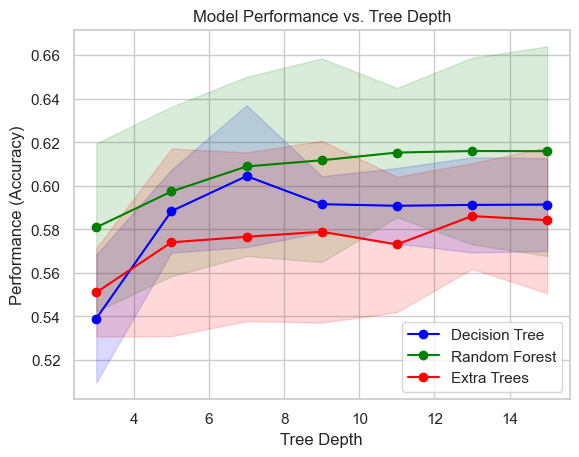

In [219]:
from sklearn.ensemble import ExtraTreesClassifier

# Define the hyperparameters to test
depths = [3, 5, 7, 9, 11, 13, 15]
performances_dt = []
performances_rf = []
performances_et = []

# Decision Tree
for depth in depths:
    parameters_dt = {
        "criterion": "gini",
        "max_depth": depth,
        "min_samples_leaf": 20
    }
    print(f"Decision Tree - Profondeur: {depth}: ")
    performance_dt = stratified_cross_validation(X, y, DecisionTreeClassifier, parameters_dt)
    performances_dt.append(performance_dt)

# Random Forest
for depth in depths:
    parameters_rf = {
        "n_estimators": 50,
        "criterion": "gini",
        "max_depth": depth,
        "min_samples_leaf": 20,
        "random_state": 42
    }
    print(f"Random Forest - Profondeur: {depth}: ")
    performance_rf = stratified_cross_validation(X, y, RandomForestClassifier, parameters_rf)
    performances_rf.append(performance_rf)

# Extra Trees
for depth in depths:
    parameters_et = {
        "n_estimators": 50,
        "criterion": "gini",
        "max_depth": depth,
        "min_samples_leaf": 20,
        "random_state": 42
    }
    print(f"Extra Trees - Profondeur: {depth}: ")
    performance_et = stratified_cross_validation(X, y, ExtraTreesClassifier, parameters_et)
    performances_et.append(performance_et)

# Plotting the performances against the depths for all models
plot_performance(depths, performances_dt, color='blue', label='Decision Tree')
plot_performance(depths, performances_rf, color='green', label='Random Forest')
plot_performance(depths, performances_et, color='red', label='Extra Trees')

# Adding titles and labels
plt.title("Model Performance vs. Tree Depth")
plt.xlabel("Tree Depth")
plt.ylabel("Performance (Accuracy)")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()